In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import pymc as pm
from scipy import stats
from scipy.stats import norm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Generate a generic dataset

In [2]:
# artificial data

seed = 123

np.random.seed(seed)

group_a = {
    'mean': 10,
    'std': 2,
    'n': 10000
}

group_b = {
    'mean': 12,
    'std': 2,
    'n': 10000
}

# generate data
x_a = np.random.normal(group_a['mean'], group_a['std'], group_a['n'])
x_b = np.random.normal(group_b['mean'], group_b['std'], group_b['n'])

# frequentist ate of diff in means of xa and xb
df = pd.DataFrame(np.concatenate([x_a, x_b]), columns=['metric'])
df['group'] = [0] * group_a['n'] + [1] * group_b['n']
df

,metric,group
0,7.828739,0
1,11.994691,0
2,10.565957,0
3,6.987411,0
4,8.842799,0
...,...,...
19995,10.105491,1
19996,11.482778,1
19997,9.194320,1
19998,14.089082,1


# Frequentist inference 

In [3]:
# frequentist ATE using linear regression to obtain maximum likelihood estimate

# estimate ate
model = lm.LinearRegression()
model.fit(df[['group']], df['metric'])  # model: metric = ate * group + intercept
ate = model.coef_[0]
intercept = model.intercept_


# Residuals and standard error of the coefficient
residuals = df['metric'] - model.predict(df[['group']])
rss = np.sum(residuals ** 2)  # Residual Sum of Squares
dof = df.shape[0] - 2  # Degrees of freedom
x_var = np.var(df['group'], ddof=1) * df.shape[0]  # Variance of group (scaled)
# Standard error of ate
se_ate = np.sqrt(rss / dof / x_var)

# Confidence interval
alpha = 0.01
t_val = stats.t.ppf(1 - alpha / 2, dof)
ci = [ate - t_val * se_ate, ate + t_val * se_ate]

print(ate, ci)
print(intercept)

# uplift
print((ate + intercept) / intercept)
print("uplift", (ate + intercept) / intercept - 1)

2.0013286204002543 [1.9284397905108386, 2.07421745028967]
10.019423784583191
1.199744881884294
uplift 0.19974488188429396


In [4]:
# using statsmodels
import statsmodels.api as sm

alpha = 0.01

model = sm.OLS(df['metric'], sm.add_constant(df['group']))
results = model.fit()

ate = results.params['group']
ci_ate = results.conf_int(alpha=alpha).loc['group'].values

intercept = results.params['const']
ci_intercept = results.conf_int(alpha=alpha).loc['const'].values

print(ate, ci_ate)
print(intercept, ci_intercept)
print((ate + intercept) / intercept)
print("uplift", (ate + intercept) / intercept - 1)

results.summary()

2.0013286204000647 [1.92843797 2.07421927]
10.019423784583271 [ 9.96788231 10.07096526]
1.1997448818842733
uplift 0.1997448818842733


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 metric   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     5003.
Date:                Sun, 26 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:56:38   Log-Likelihood:                -42248.
No. Observations:               20000   AIC:                         8.450e+04
Df Residuals:                   19998   BIC:                         8.452e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0194      0.020    500.777      0.000       9.980      10.059
group          2.0013      0.028     70.730      0.000       1.946       2.057
==============================================================================
Omnibus:                        1.861   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.394   Jarque-Bera (JB):                1.875
Skew:                           0.016   Prob(JB):                        0.392
Kurtosis:                       2.965   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Bayesian inference closed formulas

In [6]:
# bayesian of a continuous variable: data is Normal, prior is Normal, posterior is Normal; variance is known
mu0_a = 0
sigma0_a = 10
mu0_b = 0
sigma0_b = 10

sigma_data = np.std(df['metric'])

mu0_a_updated = (((1 / sigma0_a ** 2) + (group_a['n'] / sigma_data ** 2)) ** -1) * ((mu0_a / sigma0_a) ** 2 + np.sum(x_a) / sigma_data ** 2)
mu0_b_updated = (((1 / sigma0_b ** 2) + (group_b['n'] / sigma_data ** 2)) ** -1) * ((mu0_b / sigma0_b) ** 2 + np.sum(x_b) / sigma_data ** 2)

ate = mu0_b_updated - mu0_a_updated
# confidence interval
alpha = 0.01
t_val = stats.t.ppf(1 - alpha / 2, dof)
ci = [ate - t_val * sigma_data, ate + t_val * sigma_data]

print(ate, ci)
print(mu0_a_updated)
print("uplift: ", (mu0_a_updated + ate) / mu0_a_updated, mu0_b_updated / mu0_a_updated - 1)


2.001318605741247 [-3.7612817224690076, 7.763918933951501]
10.019373647333556
uplift:  1.1997448818842937 0.19974488188429373


In [7]:
# Given priors
mu0_a = 0
sigma0_a = 10
mu0_b = 0
sigma0_b = 10

# Data
sigma_data = np.std(df['metric'])
n_a = group_a['n']
n_b = group_b['n']

# Posterior updates
posterior_var_a = 1 / (1 / sigma0_a**2 + n_a / sigma_data**2)
posterior_mean_a = posterior_var_a * (mu0_a / sigma0_a**2 + np.sum(x_a) / sigma_data**2)

posterior_var_b = 1 / (1 / sigma0_b**2 + n_b / sigma_data**2)
posterior_mean_b = posterior_var_b * (mu0_b / sigma0_b**2 + np.sum(x_b) / sigma_data**2)

# ATE and standard deviation
ate = posterior_mean_b - posterior_mean_a
sigma_ate = np.sqrt(posterior_var_a + posterior_var_b)

# Credible interval
alpha = 0.01
z_val = norm.ppf(1 - alpha / 2)
ci = [ate - z_val * sigma_ate, ate + z_val * sigma_ate]

# Uplift
uplift = posterior_mean_b / posterior_mean_a - 1

print("ATE:", ate)
print("Credible Interval:", ci)
print("Posterior Mean A:", posterior_mean_a)
print("Posterior Mean B:", posterior_mean_b)
print("Uplift:", uplift)


ATE: 2.001318605741247
Credible Interval: [1.9198311125904775, 2.0828060988920165]
Posterior Mean A: 10.019373647333556
Posterior Mean B: 12.020692253074802
Uplift: 0.19974488188429373


# Bayesian inference with pymc model

In [9]:
mu0_a = 0
mu0_b = 0
sigma0_a = 10
sigma0_b = 10
prior_sigma = 10

# Define the PyMC model
model = pm.Model()
# Bayesian modeling
with model:
    # Priors for group means
    mu_a = pm.Normal('mu_a', mu=mu0_a, sigma=sigma0_a)
    mu_b = pm.Normal('mu_b', mu=mu0_b, sigma=sigma0_b)
    
    # Shared standard deviation prior
    sigma = pm.HalfNormal('sigma', sigma=prior_sigma)
    
    # Likelihood
    likelihood = pm.Normal(
        'likelihood', 
        mu=pm.math.switch(
            df['group'], 
            mu_b, 
            mu_a
        ), 
        sigma=sigma, 
        observed=df['metric'])
    
    # Calculate ATE
    ate = pm.Deterministic('ate', mu_b - mu_a)
    
    # loss = 

    
model.named_vars

# # Summarize the results
# import arviz as az

# summary = az.summary(trace, var_names=['mu_a', 'mu_b', 'ate'])
# print(summary)

# # Plot posterior distributions
# az.plot_posterior(trace, var_names=['mu_a', 'mu_b', 'ate'], hdi_prob=0.95)


{'mu_a': mu_a ~ Normal(0, 10),
 'mu_b': mu_b ~ Normal(0, 10),
 'sigma': sigma ~ HalfNormal(0, 10),
 'likelihood': likelihood ~ Normal(f(mu_b, mu_a), sigma),
 'ate': ate ~ Deterministic(f(mu_a, mu_b))}

In [10]:
model

      mu_a ~ Normal(0, 10)
      mu_b ~ Normal(0, 10)
     sigma ~ HalfNormal(0, 10)
       ate ~ Deterministic(f(mu_a, mu_b))
likelihood ~ Normal(f(mu_b, mu_a), sigma)

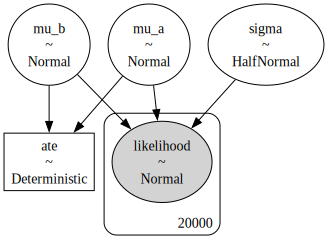

In [11]:
# requires brew/choco install graphviz in your local machine and add python package to pyproject.toml as well
pm.model_to_graphviz(model)

In [12]:
n_draws_per_chain = 1000
n_tune = 1000
n_chains = 4
n_cores = 4
with model:
    # Sample from the posterior
    trace = pm.sample(
        draws=n_draws_per_chain,
        tune=n_tune,
        chains=n_chains,
        cores=n_cores,
        random_seed=seed,
        progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, mu_b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [13]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'ate'}>, <Axes: title={'center': 'ate'}>]],
      dtype=object)

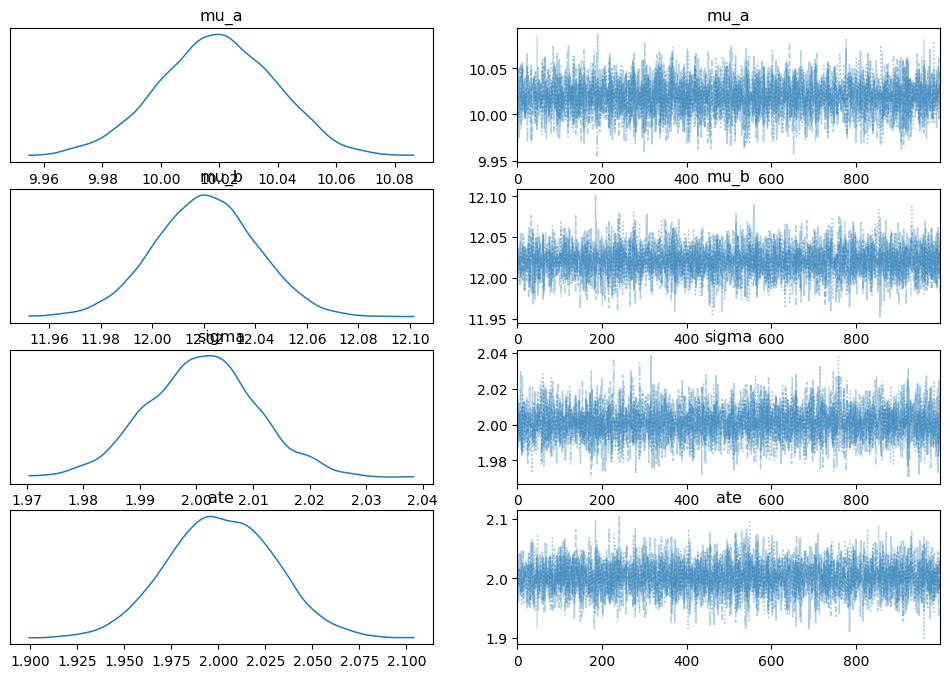

In [14]:
import arviz as az
az.plot_trace(trace, combined=True, var_names=['mu_a', 'mu_b', 'sigma', 'ate'])

In [15]:
print(az.summary(trace))

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_a   10.019  0.020   9.981   10.055        0.0      0.0    6100.0    2860.0   
mu_b   12.021  0.020  11.985   12.059        0.0      0.0    6516.0    3422.0   
sigma   2.001  0.010   1.983    2.020        0.0      0.0    6304.0    3057.0   
ate     2.001  0.028   1.947    2.053        0.0      0.0    6467.0    3184.0   

       r_hat  
mu_a     1.0  
mu_b     1.0  
sigma    1.0  
ate      1.0  


array([<Axes: title={'center': 'mu_a'}>, <Axes: title={'center': 'mu_b'}>,
       <Axes: title={'center': 'sigma'}>, <Axes: title={'center': 'ate'}>],
      dtype=object)

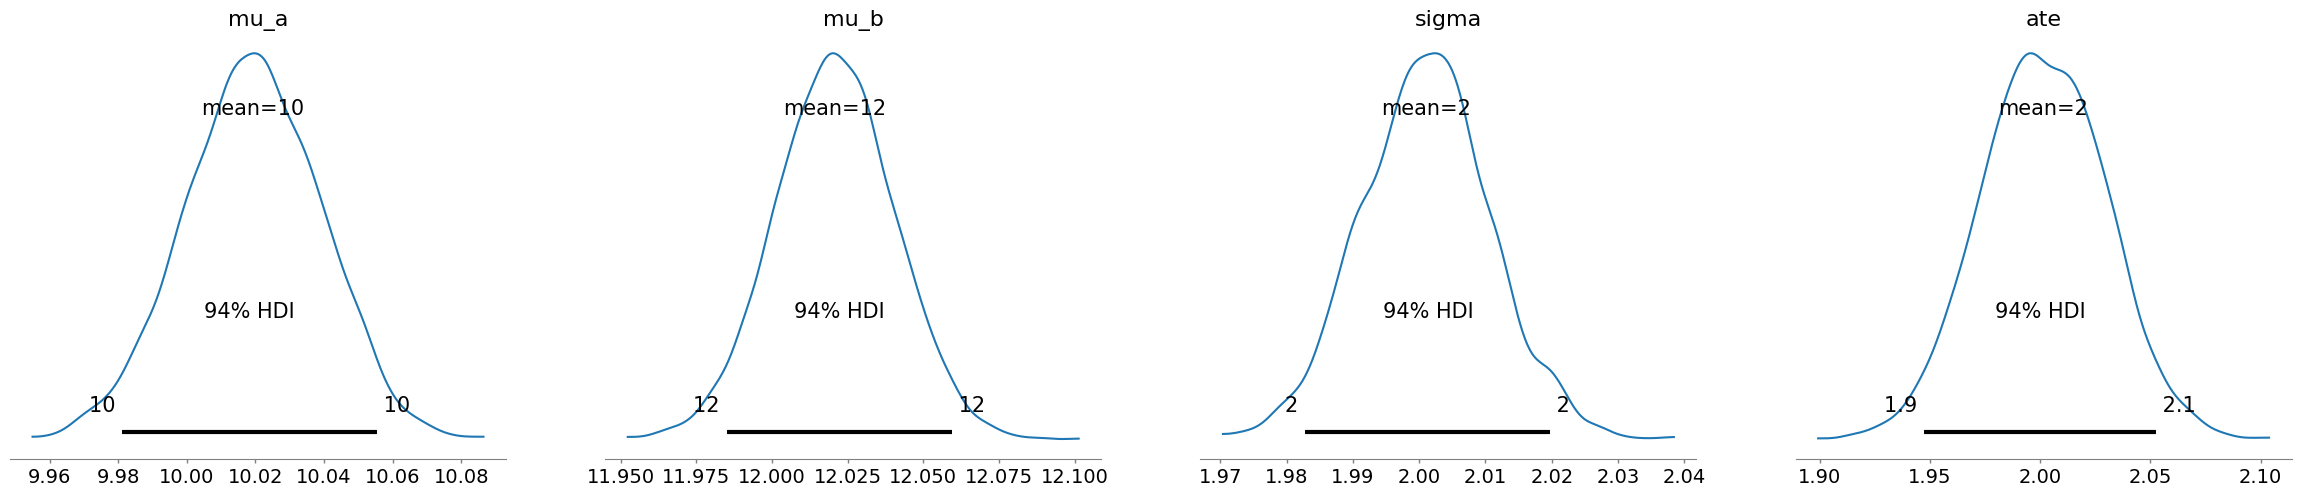

In [16]:
# Plot posterior distributions
az.plot_posterior(trace, var_names=['mu_a', 'mu_b', 'sigma', 'ate'])